Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Mallika Bagepalli Rajasekhara"
COLLABORATORS = ""

---

In [2]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."

In [3]:
"""
Setting work environment with dataset. If on Google colaboratory, we need to extract dataset stored in google drive,
otherwise the dataset is already there.
"""
try:
    from google.colab import drive
    print('Running on Google colab...')
    drive.mount('/content/drive')
    import zipfile
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/csci5931sp22/PA2-dataset/Archive.zip', 'r') as zip_ref:
        zip_ref.extractall('dataset/')
except:
    print('Running on local machine...')

Running on local machine...


In [4]:
# === Imports === #
# Various python packages are used in this notebook. Please get yourself used to them (optional).
import pandas as pd  # used for storing a tabular representation of the dataset, similar to XLS files.
from pathlib import Path # used to check if the saved model files and accessories.
import requests #used to request remote judge.csv evaluation 
from sklearn.preprocessing import StandardScaler  # used for normalization of dataset
from sklearn.preprocessing   import LabelBinarizer    # used for splitting the gender column
from sklearn.preprocessing   import MinMaxScaler      # used for normalization of dataset
from sklearn.model_selection import train_test_split  # used for performing the train-test split of a dataframe
import cv2                                            # OpenCV used for image processing
import random   #random number generator
import datetime #used to get current date/time
import math     #math/numerical functions
import os       #os specific functions, like file open/close etc.
import gc       #garbage collection module -- used to manually clean up memory spaces/references.


from sklearn.preprocessing import OneHotEncoder   #My favorite categorical to numerical feature conversion tool
from tensorflow import keras  # keras used for construction of the Artificial neural network
from keras.models import Sequential #keras model architectures
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten,Dropout, BatchNormalization #types of layers
from keras.losses import mean_squared_error, huber, log_cosh  #built-in loss 
from tensorflow.python.keras.saving import hdf5_format  #used for saving models 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard  #callbacks
from keras.models import model_from_json  #used for loading model architecture from json file
import h5py  #saved model type

import matplotlib.pyplot as plt  # used for training visualization
import numpy as np  # numpy arrays used for matrix computations

# === Extra Configurations for the GPU Environment === #
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0: #If you have at least one "configured" GPU, let's use it; otherwise, pass
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# === Random Seed Initialization === #
random_seed = 54321  # will be passed into every function which accepts a random seed/state
                     # so that, all submissions will produce the same output.
Path("saved_models/").mkdir(parents=True, exist_ok=True)  #create a directory to save model files

## Task 0: Preprocessing Data (10 points)


### Read the data about the image dataset

Let's read the data about the image dataset from `dataset/wiki_labels.csv`.

In [5]:
wiki_labels = pd.read_csv( 'dataset/wiki_labels.csv' )
wiki_labels.head( ) #printing first 5 rows from the metadata

,ID,dob,dob_str,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,age
0,2002,723671,['05-May-1981'],2009,['17/10000217_1981-05-05_2009.png'],1.0,['Sami Jauhojärvi'],[[111.29109473 111.29109473 252.66993082 252.6...,4.300962388,NaN,27.746119
1,2003,711677,['03-Jul-1948'],2008,['12/100012_1948-07-03_2008.png'],1.0,['Marc Okrand'],[[113.52 169.84 366.08 422.4 ]],4.329328832,NaN,59.582192
2,2004,705061,['23-May-1930'],1961,['65/10001965_1930-05-23_1961.png'],1.0,['Aleksandar Matanović'],[[ 1 1 634 440]],#NAME?,NaN,30.696804
3,2005,720044,['31-May-1971'],2012,['16/10002116_1971-05-31_2012.png'],0.0,['Diana Damrau'],[[171.61031405 75.5745124 266.76611571 170.7...,3.408442415,NaN,40.672146
4,2006,716189,['09-Nov-1960'],2012,['02/10002702_1960-11-09_2012.png'],0.0,['Krista Tippett'],[[274.7656324 57.77009008 376.88699455 159.8...,4.748056378,NaN,51.224201


You will notice the metadata has 11 columns namely:

1. **ID**: identification number of the subject (starting from 2002)
2. **dob**: the date of birth of the subject. (It is Matlab’s datenum value calculated based on total number of days since January 0, 0000.)
3. **dob_str**: the DD-MMM-YYYY format dob value.
4. **photo_taken**: when the photo was taken (only the year value)
5. **full_path**: directory path, including filename of the image
6. **gender**: Gender of the subject (0: female, 1: male, NaN if unknown)
7. **name**: name of the subject
8. **face_location**: location of the face.
9. **face_score**: detector score (the higher the better). `Inf` implies that no face was found in the image, and the `face_location` then just returns the entire image.
10. **second_face_score**: detector score of the face with the second highest score. This is useful to ignore images with more than one face. `second_face_score` is NaN (not a number) if no second face was detected.
11. **age**: age of the person (in years), and was calculated based on the “dob” value and the “photo_taken” values.

### Cleaning dataset
1. **First note about the dataset**: Some rows in the training dataset have an age of 0 because the image doesn't correspond to a person's face. In order to counter this dirty data, we need to remove these bad rows from the dataset as we intend to build models to predict age of a person from a given photo/portrait of the person.

2. **Second note about the dataset**: The `face_score` attribute have the chance of containing `"#NAME?"` which is likely meant to represent non-face image samples. We need to remove these too. 

In [6]:
def clean_dataset(data):
    '''
    This function takes the wiki_labels type pandas.DataFrame as the data input.
    Then returns a cleaned dataframe following the 2 notes mentioned above in the description.
    '''
    # YOUR CODE HERE
    data = data[(data['age'] > 0)]
    data = data[(data['face_score'] != "#NAME?")]
    return data
    #end of the code

In [7]:
assert len(wiki_labels)==60327

assert len(clean_dataset(wiki_labels))==42855

### Loading image dataset

In [8]:
#lean the wiki_labels information dataset.
wiki_labels_clean = clean_dataset(wiki_labels)

#Extract the path & target ['age'] for the input images
X_paths = wiki_labels_clean['full_path']
y_age = wiki_labels_clean['age']

#Finally, train-test split (80-20)
X_train_paths,X_test_paths, y_train, y_test = train_test_split(X_paths,y_age,test_size=0.2,shuffle=random_seed)

In [9]:
#Now load the images
#All images are 100x100 resolution. Let's pre-allocate the image container for efficiency purpose
X_train_images = np.zeros( shape = (len(X_train_paths),100,100),dtype=np.float32)

i = 0
for p in X_train_paths:
    p = p.replace('[','').replace(']','').replace('\'','')
    fpath = '{}/{}'.format('dataset/wiki_labeled/',p)
    X_train_images[i] = cv2.imread(fpath,cv2.IMREAD_GRAYSCALE) / 255.0  #load & scale
    i += 1


#Reshaping to fit for Keras Tensor usage
X_train_images = X_train_images.reshape(
    X_train_images.shape[0],
    X_train_images.shape[1],
    X_train_images.shape[2],
    1
)


In [10]:
#Now load the test images
#All images are 100x100 resolution. Let's pre-allocate the image container for efficiency purpose
X_test_images = np.zeros( shape = (len(X_test_paths),100,100),dtype=np.float32)

i = 0
for p in X_test_paths:
    p = p.replace('[','').replace(']','').replace('\'','')
    fpath = '{}/{}'.format('dataset/wiki_labeled/',p)
    X_test_images[i] = cv2.imread(fpath,cv2.IMREAD_GRAYSCALE) / 255.0
    i += 1

X_test_images = X_test_images.reshape(
    X_test_images.shape[0],
    X_test_images.shape[1],
    X_test_images.shape[2],
    1
)

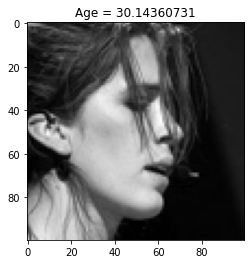

In [11]:
#Pick a random number and display it.
idx = random.randint(0,X_train_images.shape[0])
img = X_train_images[idx]
plt.figure()
plt.imshow(img.squeeze(), cmap='gray')
plt.title('Age = {}'.format(y_train.iloc[idx]))
plt.show()

## Task 1: Model 1:: Building your first Convolution Neural Network (CNN) model (10pts)

Let's build your first convolution neural network (CNN), CNN_A with the following configuration:

* Following is the sequential structure:
    - size of the Kernels used in all `Conv2D` layers is (3,3), padding=`valid` 
    - `pool_size` of (2,2) was used in all of `MaxPool2D` layers.
* Select `activation` for all the units in the CNN architecture "wisely". Keras provides a good number of activation functions. Details can be obtained here [Keras.layers activations](https://keras.io/api/layers/activations/)


Model: "sequential"

| Layer type| Output Shape | Param # (roughly)|
| :----------- | :----------- |------------|
|Conv2D   |          (None, 98, 98, 32)  |      320       |
| MaxPooling2D |  (None, 49, 49, 32)  |     0      |   
| Conv2D           | (None, 47, 47, 64)   |     18496    | 
| MaxPooling2D |  (None, 23, 23, 64) |      0        |
| Conv2D           | (None, 21, 21, 128)  |     73856     |
| MaxPooling2D | (None, 10, 10, 128) |     0          |                                       
| Flatten     |      (None, 12800)   |          0      |   
| Dense          |     (None, 64)       |         819264   | 
| Dropout       |    (None, 64)        |        0         |
| Dense         |    (None, 1)          |       65  |

In [12]:
def my_CNN_model_A(loss,optimizer,metrics):
    model = Sequential()
    
    # YOUR CODE HERE
    # YOUR CODE HERE
    #1st convolution layer
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid', input_shape=(100, 100, 1)))
    model.add(MaxPool2D(pool_size=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='linear'))
    #end of the code

    # finally, compile with the provided optimizer to optimize the given loss object.
    # Also, list of metrics are going to be computed during each epoch.
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    return model

* Use `mean_squared_error` as the loss function for this problem. It is one of the built-in Keras loss function.
    * Details about it can be obtained here [Keras loss function](https://keras.io/api/losses/regression_losses/)
* Use `adam` as the optimizer. It is one of the built-in Keras optimizer for backpropagation/gradient descent. Details can be found here [Keras optimizers](https://keras.io/api/optimizers/)
* Make sure to print the 4 metrics during every training epochs: 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error',  'cosine_similarity', 'logcosh'. Details about the metrics defined in Keras can be found here [Keras metrics](https://keras.io/api/metrics/regression_metrics/)



In [13]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please take a careful note at how it was called.
model1 = my_CNN_model_A(loss='mean_squared_error',
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

2022-03-16 19:38:21.467330: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
# Calling summary() to see if the model architecture requirements are met or not.
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

In [15]:
def check_network_architecture(model, expected_layer_shapes, 
                               expected_params,
                               expected_loss_function
                              ):
    #This function checks a model's basic architecture
    layer_shapes = []
    for layer in model.layers:
        layer_shapes.append(layer.output_shape)

    so_far_so_good = False
    if layer_shapes == expected_layer_shapes:
        if model.count_params()==expected_params:
            if model.loss == expected_loss_function:
                so_far_so_good = True
    return so_far_so_good

In [16]:
"""Check if the network is compiled according to the specification"""

assert  check_network_architecture(model1, 
                                  expected_layer_shapes=[(None, 98, 98, 32), (None, 49, 49, 32), (None, 47, 47, 64), (None, 23, 23, 64), (None, 21, 21, 128), (None, 10, 10, 128), (None, 12800), (None, 64), (None, 64), (None, 1)],
                                  expected_params=912001,
                                  expected_loss_function='mean_squared_error') == True

In [17]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

epochs = 50  #number of epochs to run the training on
batch_size = 128 #batch size

#Train and test dataset for the training & validation
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#prefix to model names for saving
model_path = 'saved_models/model1.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [18]:
def lets_train_model(model, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks=callbacks):
    #This function must call the model.fit() function with appropriate parameters:
    #
    # Input parameters:
    # x_train, y_train : are the training set prepared above
    # epochs : number of epochs to run (unless early stopping callback kicks in)
    # batch_size : the batch_size to use during weight update (mini-batch gradient descent)
    # x_test, y_test : to be passed as validation_data to validate the partially trained model after each epoch
    # callbacks : the list of 4 callbacks prepared in the previous cell to be passed to the fit() function
    #
    # Returns a list of the following 2:
    #  history : return value of model.fit() call
    #  model   : the fit model
    
    history = [] #it should store whatever the model.fit() function returns
    
    # YOUR CODE HERE
    history = model.fit(x_train, y_train, epochs, batch_size, validation_data=(x_test, y_test), callbacks=callbacks)
    #end of the code
    
    return [history, model]

In [19]:
# Now, call the lets_train_model() above with appropriate parameters to train model1.
# Please store the list of [history, model1] returned from the call.

# YOUR CODE HERE
[history, model1] = lets_train_model(model1, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
#end of the code

Epoch 1/128
686/686 [==============================] - 201s 291ms/step - loss: 370.1962 - mean_absolute_percentage_error: 42.7766 - mean_absolute_error: 14.6548 - mean_squared_logarithmic_error: 0.2654 - cosine_similarity: 0.9995 - logcosh: 13.9811 - val_loss: 281.3325 - val_mean_absolute_percentage_error: 40.7833 - val_mean_absolute_error: 12.9580 - val_mean_squared_logarithmic_error: 0.1615 - val_cosine_similarity: 1.0000 - val_logcosh: 12.2798 - lr: 0.0010
Epoch 2/128
686/686 [==============================] - 209s 304ms/step - loss: 323.4319 - mean_absolute_percentage_error: 40.0249 - mean_absolute_error: 13.6377 - mean_squared_logarithmic_error: 0.2055 - cosine_similarity: 1.0000 - logcosh: 12.9660 - val_loss: 255.7640 - val_mean_absolute_percentage_error: 32.6182 - val_mean_absolute_error: 11.4684 - val_mean_squared_logarithmic_error: 0.1329 - val_cosine_similarity: 1.0000 - val_logcosh: 10.7978 - lr: 0.0010
Epoch 3/128
686/686 [==============================] - 213s 310ms/step -

Epoch 19/128
686/686 [==============================] - 229s 333ms/step - loss: 162.6897 - mean_absolute_percentage_error: 27.5887 - mean_absolute_error: 9.5263 - mean_squared_logarithmic_error: 0.1097 - cosine_similarity: 1.0000 - logcosh: 8.8629 - val_loss: 180.4306 - val_mean_absolute_percentage_error: 28.5322 - val_mean_absolute_error: 9.2277 - val_mean_squared_logarithmic_error: 0.0995 - val_cosine_similarity: 1.0000 - val_logcosh: 8.5680 - lr: 0.0010
Epoch 20/128
686/686 [==============================] - 219s 320ms/step - loss: 157.3961 - mean_absolute_percentage_error: 27.0354 - mean_absolute_error: 9.3289 - mean_squared_logarithmic_error: 0.1058 - cosine_similarity: 1.0000 - logcosh: 8.6671 - val_loss: 181.8890 - val_mean_absolute_percentage_error: 25.4522 - val_mean_absolute_error: 8.9855 - val_mean_squared_logarithmic_error: 0.0973 - val_cosine_similarity: 1.0000 - val_logcosh: 8.3263 - lr: 0.0010
Epoch 21/128
686/686 [==============================] - 220s 320ms/step - loss

In [20]:
# checking if the training was successful
assert( all(key in history.history for key in ('loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'val_mean_squared_logarithmic_error', 'val_cosine_similarity', 'val_logcosh')))
#assert(len(history.history['loss'])==epochs)


In [21]:
# Save model
def save_model(model_path, model, name, description):
    # This function takes the prefix of the model_path and a name and description as input
    # and saves the architecture as a json file and weights as additional file.
    # The best model is already saved by the mcp_callback during the fit() call with extension *.mcp.hdf5
    
    # Step 1: serialize model architecture to *.json file
    model_json = model.to_json()
    with open(model_path+".json", "w") as json_file:
        json_file.write(model_json)

    #Step 2: now the model weights + additional attributes as *.additional
    with h5py.File(model_path+'.additional', mode='w') as f:
        hdf5_format.save_model_to_hdf5(model, f)
        f.attrs['name'] = name
        f.attrs['description'] = description


In [22]:
#load model
def load_model(model_path):
    # This function loads from the 3 files: *.json, *.additional, *.mcp.hdf5 located at the model_path prefix
    # and returns the best model, it's name and description
    
    mode = []
    name = 'NA'
    descripton = 'NA'
    with open(model_path+'.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json) #load the architecture
        model.load_weights(model_path+'.mcp.hdf5') #load the weights (from the ModelCheckPoint)
        
        with h5py.File(model_path+'.additional', mode='r') as f: #load the additional name/description info
            name = f.attrs['name']
            description = f.attrs['description']
    return [model, name, description]

In [23]:
# Saving model1
save_model(model_path, model=model1, name='Model1', description='CNN-A with built-in MSE loss')

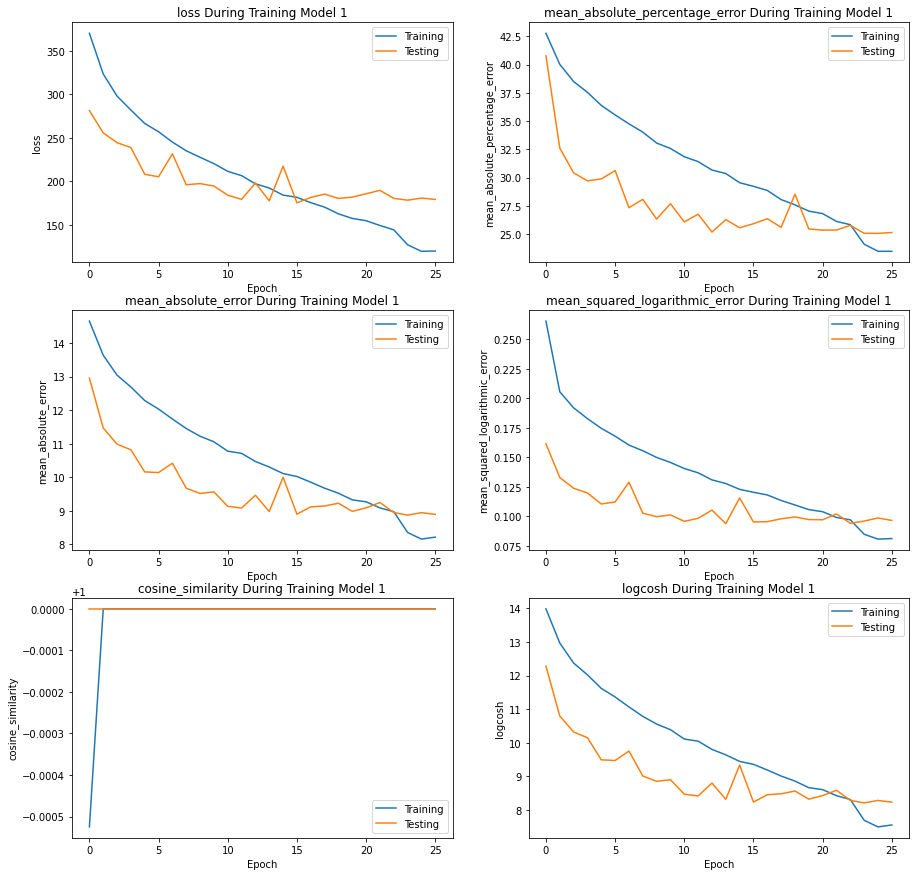

In [24]:
# === Plot the model1 training and validation performance === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 1' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [25]:
# a little memory management -- mandatory if eager-execution is enabled
del model1
gc.collect()


19488

## Task 2: Model 2:: Second Convolution Neural Network (CNN) model (10pts)

Let's build your second convolution neural network (CNN), CNN_B with the following configuration:

* Following is the sequential structure:
    - size of the Kernels used in all `Conv2D` layers is (3,3), padding=`valid` 
    - `pool_size` of (2,2) was used in all of `MaxPool2D` layers.
* Select `activation` for all the units in the CNN architecture "wisely". Keras provides a good number of activation functions. Details can be obtained here [Keras.layers activations](https://keras.io/api/layers/activations/)



Model: "sequential"

| Layer type| Output Shape | Param # (roughly)|
| :----------- | :----------- |------------|
|Conv2D   |          (None, 98, 98, 32)  |      320       |
| BatchNormalization |  (None, 98, 98, 32) |      128    |       
| Dropout      |  (None, 98, 98, 32)  |      0 |
| MaxPooling2D |  (None, 49, 49, 32)  |     0      |   
| Conv2D           | (None, 47, 47, 64)   |     18496    |
| BatchNormalization | (None, 47, 47, 64) |       256   |        
| Dropout      |        (None, 47, 47, 64) |       0   | 
| MaxPooling2D |  (None, 23, 23, 64) |      0        |
| Conv2D           | (None, 21, 21, 128)  |     73856     |
| BatchNormalization |  (None, 21, 21, 128) |     512    |       
| Dropout      |  (None, 21, 21, 128)  |     0   |
| MaxPooling2D | (None, 10, 10, 128) |     0          |                                       
| Flatten     |      (None, 12800)   |          0      |   
| Dense          |     (None, 64)       |         819264   | 
| Dropout       |    (None, 64)        |        0         |
| Dense         |    (None, 1)          |       65  |

In [27]:
def my_CNN_model_B(loss,optimizer,metrics):
    model = Sequential()
    
    # YOUR CODE HERE
    #1st convolution layer
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid', input_shape=(100, 100, 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(MaxPool2D(pool_size=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(MaxPool2D(pool_size=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    #end of code

    # finally, compile with the provided optimizer to optimize the given loss object.
    # Also, list of metrics are going to be computed during each epoch.
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    return model

* Use `mean_squared_error` as the loss function for this problem. It is one of the built-in Keras loss function. Details about it can be obtained here [Keras loss function](https://keras.io/api/losses/regression_losses/)
* Use `adam` as the optimizer. It is one of the built-in Keras optimizer for backpropagation/gradient descent. Details can be found here [Keras optimizers](https://keras.io/api/optimizers/)
* Make sure to print the 4 metrics during every training epochs: 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error',  'cosine_similarity', 'logcosh'. Details about the metrics defined in Keras can be found here [Keras metrics](https://keras.io/api/metrics/regression_metrics/)



In [28]:
# I've called my_CNN_model_B() function following the requirements above. 
# Please take a careful note at how it was called.
model2 = my_CNN_model_B(loss='mean_squared_error',
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [29]:
"""Check if the network is compiled according to the specification"""

assert  check_network_architecture(model2, 
                                  expected_layer_shapes=[(None, 98, 98, 32), (None, 98, 98, 32), (None, 98, 98, 32), (None, 49, 49, 32), (None, 47, 47, 64), (None, 47, 47, 64), (None, 47, 47, 64), (None, 23, 23, 64), (None, 21, 21, 128), (None, 21, 21, 128), (None, 21, 21, 128), (None, 10, 10, 128), (None, 12800), (None, 64), (None, 64), (None, 1)],
                                  expected_params=912897,
                                  expected_loss_function='mean_squared_error') == True

In [30]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

epochs = 50 #num of epochs
batch_size = 128 #batch size

#train-test datasets ready to be trained
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#prefix to the model save path
model_path = 'saved_models/model2.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]


In [31]:
# Now, call the lets_train_model() above with appropriate parameters to train model2.
# Please store the list of [history, model2] returned from the call.

# YOUR CODE HERE
[history, model2] = lets_train_model(model2, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
#end of the code

Epoch 1/128
686/686 [==============================] - 357s 519ms/step - loss: 332.6592 - mean_absolute_percentage_error: 39.9321 - mean_absolute_error: 13.7191 - mean_squared_logarithmic_error: 0.2478 - cosine_similarity: 0.9977 - logcosh: 13.0476 - val_loss: 561.8710 - val_mean_absolute_percentage_error: 68.4842 - val_mean_absolute_error: 19.6812 - val_mean_squared_logarithmic_error: 0.3078 - val_cosine_similarity: 1.0000 - val_logcosh: 18.9974 - lr: 0.0010
Epoch 2/128
686/686 [==============================] - 382s 556ms/step - loss: 279.5593 - mean_absolute_percentage_error: 36.6486 - mean_absolute_error: 12.5631 - mean_squared_logarithmic_error: 0.1945 - cosine_similarity: 1.0000 - logcosh: 11.8929 - val_loss: 373.1834 - val_mean_absolute_percentage_error: 53.0941 - val_mean_absolute_error: 15.4304 - val_mean_squared_logarithmic_error: 0.2193 - val_cosine_similarity: 1.0000 - val_logcosh: 14.7497 - lr: 0.0010
Epoch 3/128
686/686 [==============================] - 393s 572ms/step -

Epoch 18/128
686/686 [==============================] - 337s 491ms/step - loss: 165.5012 - mean_absolute_percentage_error: 27.4738 - mean_absolute_error: 9.5635 - mean_squared_logarithmic_error: 0.1108 - cosine_similarity: 1.0000 - logcosh: 8.9011 - val_loss: 212.5990 - val_mean_absolute_percentage_error: 32.4624 - val_mean_absolute_error: 10.3339 - val_mean_squared_logarithmic_error: 0.1192 - val_cosine_similarity: 1.0000 - val_logcosh: 9.6674 - lr: 1.0000e-04
Epoch 19/128
686/686 [==============================] - 331s 483ms/step - loss: 161.8538 - mean_absolute_percentage_error: 27.4309 - mean_absolute_error: 9.4650 - mean_squared_logarithmic_error: 0.1090 - cosine_similarity: 1.0000 - logcosh: 8.8020 - val_loss: 189.6759 - val_mean_absolute_percentage_error: 26.7006 - val_mean_absolute_error: 9.3860 - val_mean_squared_logarithmic_error: 0.1100 - val_cosine_similarity: 1.0000 - val_logcosh: 8.7237 - lr: 1.0000e-04
Epoch 20/128
686/686 [==============================] - 331s 482ms/st

In [32]:
#checking if the model2 training was okay
assert( all(key in history.history for key in ('loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh', 'val_loss', 'val_mean_absolute_percentage_error', 'val_mean_absolute_error', 'val_mean_squared_logarithmic_error', 'val_cosine_similarity', 'val_logcosh')))
#assert(len(history.history['loss'])==epochs)


In [33]:
# saving model2
save_model(model_path, model=model2, name='Model2', description='CNN-B with built-in MSE loss')

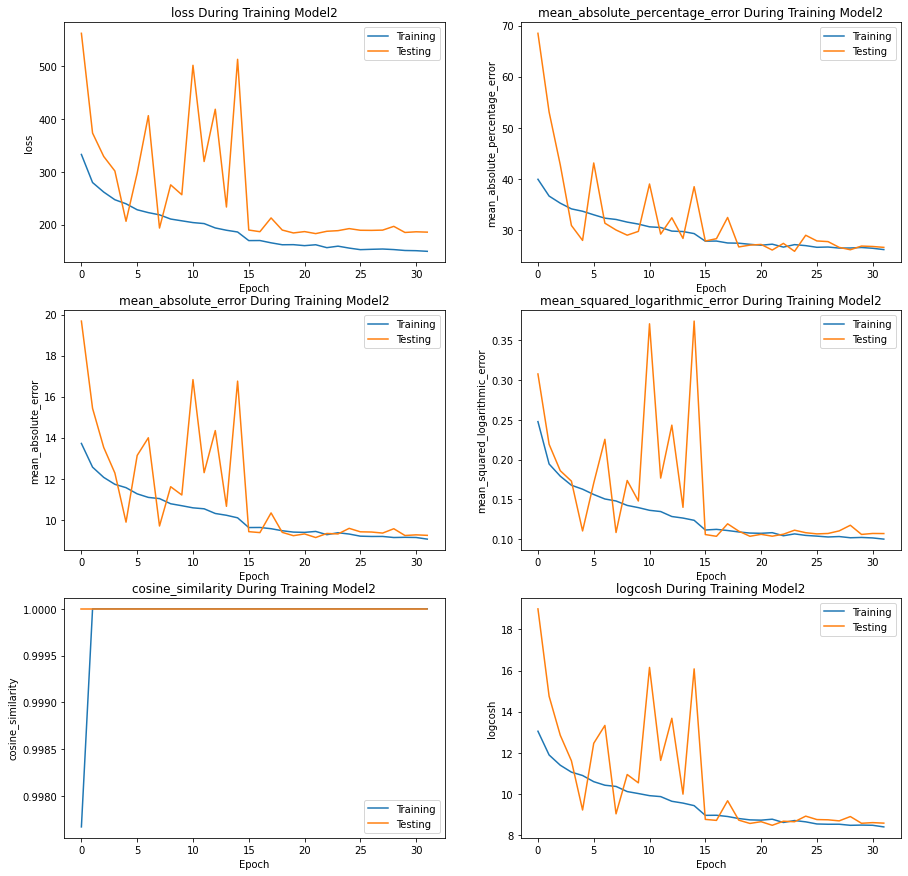

In [34]:
# === Plot the training and validation performance of model2 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model2' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [35]:
#A little memory management
del model2
gc.collect()


20976

## Task 3: Model 3:: CNN model with custom MSE loss (10pts)
* Let's define the Mean Squared Loss function ourselves and use it for the model training.
* As you know the Mean Squared Error (MSE) is the simplest and most commonly used loss function.
* The formula for MSE is 
$$ MSE(y,\hat{y}) = \dfrac{1}{N}\sum_{i=1}^N\left( y_i - \hat{y}_i\right)^2, $$
where $N$ is the total number of samples considered to compute this loss, $y$ and $\hat{y}$ are the ground-true target values and the corresponding predictions respectively.
    - MSE will never be negative, right?
    - Pros: Simplest to implement.
    - Cons: Very sensitive to outliers, or bad samples that might magnify the error too much that the gradient descent will have to experience hard-time converging/ going downhill, requiring extra steps (or longer routes). Simply speaking: slower training.
* More on MSE can be obtained here [Wiki: MSE](https://en.wikipedia.org/wiki/Mean_squared_error)

In [38]:
def TF_myMSE( y_true , y_pred ):
    # This function takes two numpy arrays / 1-D tensors of same length
    # And, it computes the MSE error. 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the mse error.
    
    mse_error = tf.constant(np.inf, dtype=tf.float32) #positive infinity
    
    # YOUR CODE HERE
    y_true = tf.cast(y_true, dtype=tf.float32) #converting to tf.float32 type
    y_pred = tf.cast(y_pred, dtype=tf.float32) #converting to tf.float32 type
    
    mse_error = tf.math.reduce_mean(tf.math.squared_difference(y_pred, y_true))
    #end of code
    return mse_error

In [39]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_myMSE([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-30.0) < 1e-3)
assert(np.abs(TF_myMSE([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_myMSE([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 6.079996) <1e-3)

In [40]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom MSE function (TF_myMSE) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model3 = my_CNN_model_A(loss=TF_myMSE,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [41]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#training and test data ready for the training & validation
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix
model_path = 'saved_models/model3.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [42]:
# Now, call the lets_train_model() above with appropriate parameters to train model3.
# Please store the list of [history, model3] returned from the call.

# YOUR CODE HERE
[history, model3] = lets_train_model(model3, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
#end of the code

Epoch 1/128
686/686 [==============================] - 173s 251ms/step - loss: 363.7560 - mean_absolute_percentage_error: 42.0790 - mean_absolute_error: 14.4849 - mean_squared_logarithmic_error: 0.2642 - cosine_similarity: 0.9980 - logcosh: 13.8119 - val_loss: 317.6983 - val_mean_absolute_percentage_error: 30.5140 - val_mean_absolute_error: 12.2990 - val_mean_squared_logarithmic_error: 0.1529 - val_cosine_similarity: 1.0000 - val_logcosh: 11.6301 - lr: 0.0010
Epoch 2/128
686/686 [==============================] - 177s 258ms/step - loss: 313.3549 - mean_absolute_percentage_error: 39.7726 - mean_absolute_error: 13.4564 - mean_squared_logarithmic_error: 0.1998 - cosine_similarity: 1.0000 - logcosh: 12.7846 - val_loss: 249.0773 - val_mean_absolute_percentage_error: 36.0000 - val_mean_absolute_error: 11.7275 - val_mean_squared_logarithmic_error: 0.1392 - val_cosine_similarity: 1.0000 - val_logcosh: 11.0540 - lr: 0.0010
Epoch 3/128
686/686 [==============================] - 178s 259ms/step -

Epoch 19/128
686/686 [==============================] - 172s 250ms/step - loss: 154.7533 - mean_absolute_percentage_error: 26.8411 - mean_absolute_error: 9.2452 - mean_squared_logarithmic_error: 0.1036 - cosine_similarity: 1.0000 - logcosh: 8.5847 - val_loss: 176.4639 - val_mean_absolute_percentage_error: 25.7808 - val_mean_absolute_error: 8.9315 - val_mean_squared_logarithmic_error: 0.0932 - val_cosine_similarity: 1.0000 - val_logcosh: 8.2736 - lr: 0.0010
Epoch 20/128
686/686 [==============================] - 172s 251ms/step - loss: 148.1989 - mean_absolute_percentage_error: 26.3384 - mean_absolute_error: 9.0803 - mean_squared_logarithmic_error: 0.0998 - cosine_similarity: 1.0000 - logcosh: 8.4183 - val_loss: 174.9567 - val_mean_absolute_percentage_error: 25.6349 - val_mean_absolute_error: 8.8273 - val_mean_squared_logarithmic_error: 0.0929 - val_cosine_similarity: 1.0000 - val_logcosh: 8.1660 - lr: 0.0010
Epoch 21/128
686/686 [==============================] - 172s 251ms/step - loss

In [43]:
#Saving model3
save_model(model_path, model=model3, name='Model3', description='CNN-A with custom MSE loss')

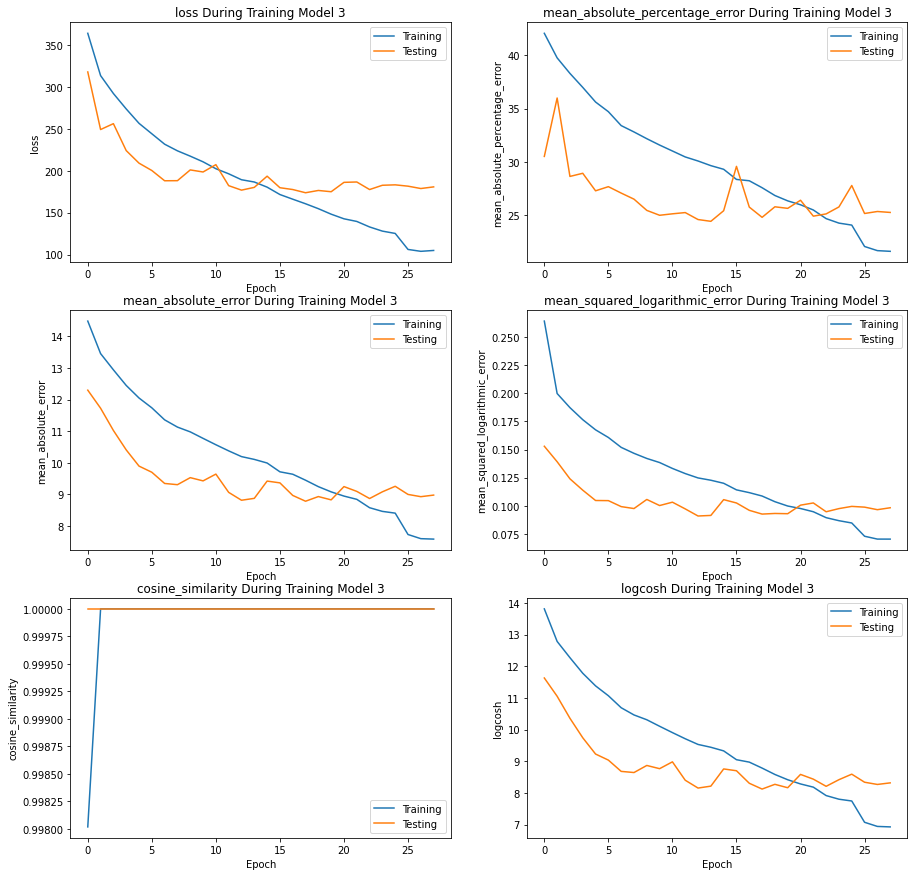

In [44]:
# === Plot the training and validation performance of model3 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 3' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [45]:
# a little memory management 
del model3
gc.collect()


24481

## Task 4: Model 4:: CNN model with huber loss (10pts)
* Let's define another loss function, namely `huber loss`. 
* Proposed by Peter Huber in 1964 which is a compromise between the mean squared error and mean absolute error functions.
* It is a piece-wise function that behaves like Squared Error for small errors, and like Absolute Error for large errors.
$$ Huber(y,\hat{y}) = \begin{cases}
\frac{1}{2}(y-\hat{y})^2 & \textrm{for } | y - \hat{y}| \le \delta,\\
\delta\, (|y-\hat{y}|-\frac{1}{2}\delta), & \textrm{otherwise.}
\end{cases}
$$
    - Please compute mean of individual huber losses over the $N$ samples considered to compute the final Huber loss, $y$ and $\hat{y}$ are the ground-true target values and the corresponding predictions respectively.
* Peter Huber argued that, $\delta=1.345$ is a good choice, and showed that asymptotically, it is 95% as efficient as least squares (i.e., MSE) if the true distribution is Gaussian (i.e, normal), and much more efficient in many other cases.
* Below is the plots of both Huber loss (Green line, with $\delta =1$) and Squared error losses (blue line).You can see, Huber loss is also convex. Therefore, we can optimize through gradient descent. yah!! 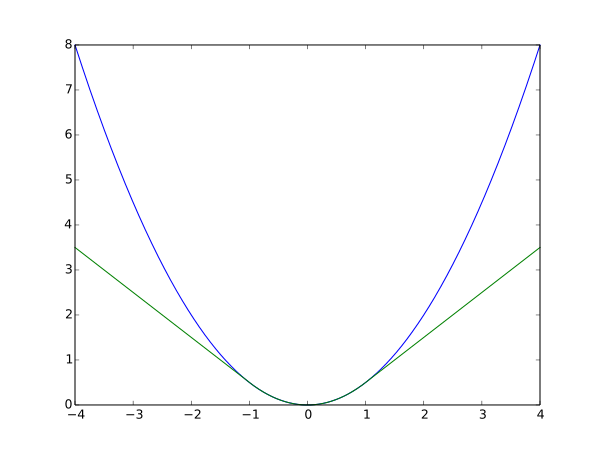
* More on this loss, here [Wiki:Huber loss](https://en.wikipedia.org/wiki/Huber_loss)

In [47]:
def TF_huber(y_true, y_pred, delta=1.345):
    # This function takes two numpy arrays / 1-D tensors of same length, a delta.
    # And, it computes the Huber loss. 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the huber loss.
    
    y_true = tf.cast(y_true, dtype=tf.float32) #converting to tf.float32 type
    y_pred = tf.cast(y_pred, dtype=tf.float32) #converting to tf.float32 type
    
    huber_loss = tf.constant(np.inf, dtype=tf.float32) #positive infinity
    
    # YOUR CODE HERE
    delta = tf.cast(delta, dtype=tf.float32)
    condition  = tf.keras.backend.abs(tf.subtract(y_true, y_pred)) < delta
    squaredloss = 0.5 * tf.keras.backend.square(tf.subtract(y_true, y_pred))
    linearloss  = delta * (tf.keras.backend.abs(tf.subtract(y_true, y_pred)) - 0.5 * delta)
    huber_loss = tf.where(condition, squaredloss, linearloss)
    huber_loss = tf.math.reduce_mean(huber_loss)
    
    
    return huber_loss

In [48]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_huber([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-5.8204875) < 1e-3)
assert(np.abs(TF_huber([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_huber([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 2.0680916) <1e-3)

In [49]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom huber loss function (TF_huber) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model4 = my_CNN_model_A(loss=TF_huber,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [50]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50  #epoch number
batch_size = 128 #batch size

#training and validation dataset ready to be used for the model.fit()
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix
model_path = 'saved_models/model4.sav'


#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [51]:
# Now, call the lets_train_model() above with appropriate parameters to train model4.
# Please store the list of [history, model4] returned from the call.

# YOUR CODE HERE
[history, model4] = lets_train_model(model4, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
#end of the code

Epoch 1/128
686/686 [==============================] - 169s 246ms/step - loss: 19.2240 - mean_absolute_percentage_error: 41.0271 - mean_absolute_error: 14.9510 - mean_squared_logarithmic_error: 0.2993 - cosine_similarity: 0.9992 - logcosh: 14.2776 - val_loss: 15.7882 - val_mean_absolute_percentage_error: 30.4500 - val_mean_absolute_error: 12.3914 - val_mean_squared_logarithmic_error: 0.1573 - val_cosine_similarity: 1.0000 - val_logcosh: 11.7249 - lr: 0.0010
Epoch 2/128
686/686 [==============================] - 172s 251ms/step - loss: 17.7458 - mean_absolute_percentage_error: 38.5908 - mean_absolute_error: 13.8505 - mean_squared_logarithmic_error: 0.2211 - cosine_similarity: 1.0000 - logcosh: 13.1790 - val_loss: 15.1129 - val_mean_absolute_percentage_error: 33.0193 - val_mean_absolute_error: 11.8932 - val_mean_squared_logarithmic_error: 0.1403 - val_cosine_similarity: 1.0000 - val_logcosh: 11.2217 - lr: 0.0010
Epoch 3/128
686/686 [==============================] - 170s 248ms/step - los

Epoch 19/128
686/686 [==============================] - 170s 247ms/step - loss: 12.2875 - mean_absolute_percentage_error: 27.7526 - mean_absolute_error: 9.7855 - mean_squared_logarithmic_error: 0.1151 - cosine_similarity: 1.0000 - logcosh: 9.1233 - val_loss: 11.3551 - val_mean_absolute_percentage_error: 24.0491 - val_mean_absolute_error: 9.0888 - val_mean_squared_logarithmic_error: 0.0959 - val_cosine_similarity: 1.0000 - val_logcosh: 8.4309 - lr: 0.0010
Epoch 20/128
686/686 [==============================] - 170s 248ms/step - loss: 12.0709 - mean_absolute_percentage_error: 27.1467 - mean_absolute_error: 9.6234 - mean_squared_logarithmic_error: 0.1115 - cosine_similarity: 1.0000 - logcosh: 8.9625 - val_loss: 11.4288 - val_mean_absolute_percentage_error: 24.3168 - val_mean_absolute_error: 9.1471 - val_mean_squared_logarithmic_error: 0.0935 - val_cosine_similarity: 1.0000 - val_logcosh: 8.4853 - lr: 0.0010
Epoch 21/128
686/686 [==============================] - 170s 248ms/step - loss: 11

In [52]:
#saving model4
save_model(model_path, model=model4, name='Model4', description='CNN-A with custom Huber loss')

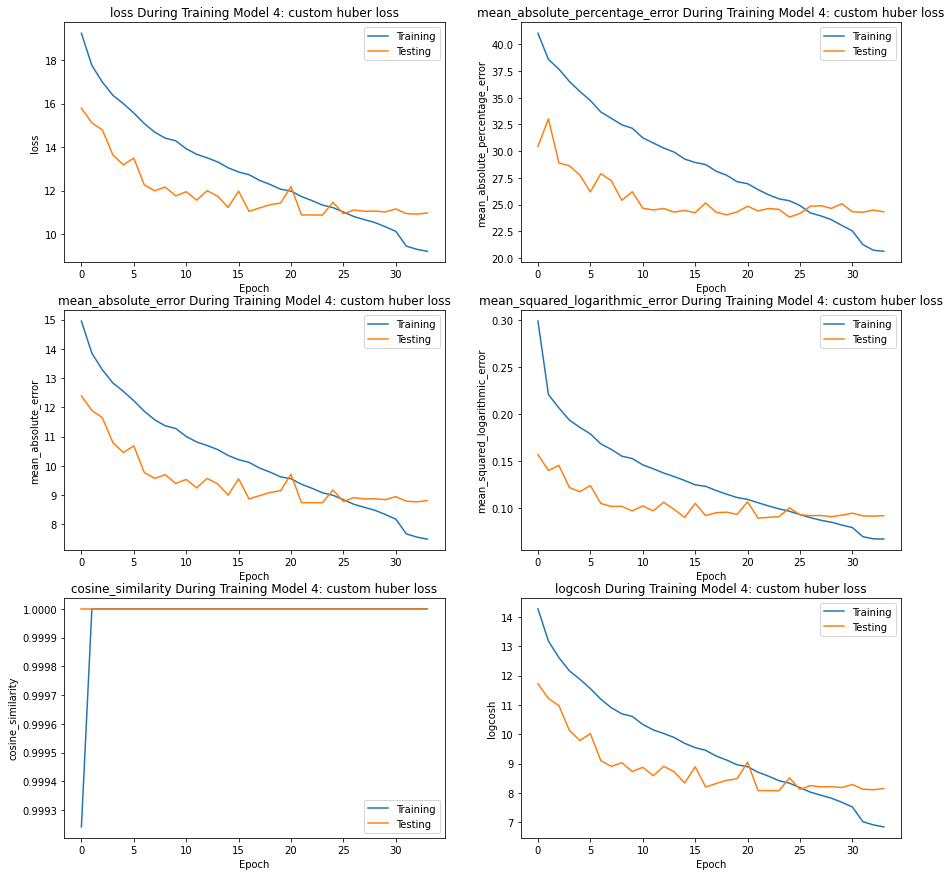

In [53]:
# === Plot the training and validation performance of model4 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 4: custom huber loss' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [54]:
#a little memory management
del model4
gc.collect()

23288

## Task 5: Model 5:: CNN model with custom LogCosh loss (10pts)
* Log Cosh loss, i.e., log hyperbolic cosine loss is getting popular in regression problems with large target values, as you don't want to penalize too much if, for example, a house price is predicted USD 325,000 rather than USD 315,00. As you may have noticed there is an 10,000 prediction error, will be terribly amplified with losses like MSE. 
    - Pros:
        * `log(cosh(x))` approximates to $\frac{x^2}{2}$ for small $x$ and $|x|-\ln 2$ for large $x$. This means, the `logCosh` function works mostly like the mean squared error, but will not be so strongly affected by the occasional wildly incorrect/ large prediction errors. 
        * It has almost all advantages of the Huber loss, and it is twice differentiable everywhere, unlike Huber loss.
* Another appealing thing with this loss is it's double differentiable. Some optimizer, like XGBoost may prefer this property.
$$ LogCosh(y, \hat{y}) = \dfrac{1}{N}\sum_{i=1}^N  \log_e[\cosh(y_i - \hat{y}_i)]$$
    * And, you know, 
$$ \log_e \cosh(x) = \log_e(\cosh(x)), $$
where $$\cosh(x) = \dfrac{e^+e^{-x}}{2} = \dfrac{1+e^{-2x}}{2e^{-x}}=\dfrac{e^{2x}+1}{2e^x}$$
    * To ensure numerical stability, please use `tf.math.softplus` function rather than simply using `tf.math.exp` as `tf.math.exp` quickly overflows with slightly bigger inputs.
$$ \mathrm{softplus}(x) = \log_e(1+e^x)$$
    * Please use $\cosh(x) = \dfrac{1+e^{-2x}}{2e^{-x}}$ for positive $x$.
    * Also use $\cosh(x) = \dfrac{e^{2x}+1}{2e^x}$ for negative $x$.

Here below is the plots of both Huber and logcosh loss functions. Both are convex. 
    - 
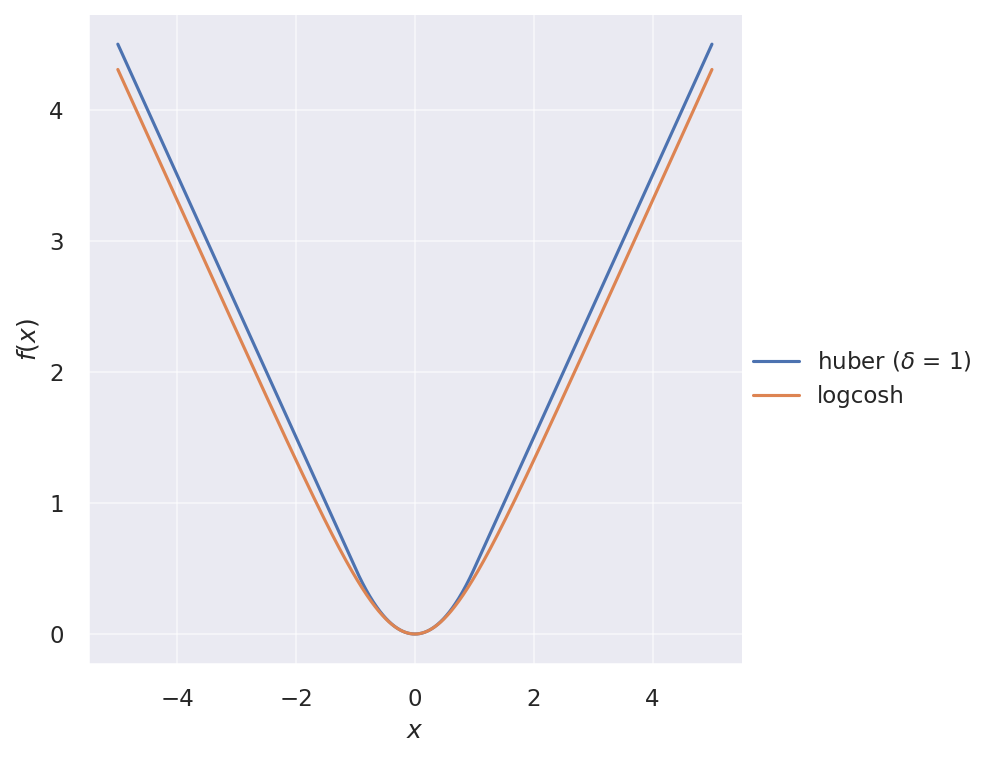

In [114]:
def TF_logcosh(y_true, y_pred):
    # This function takes two numpy arrays / 1-D tensors of same length, a delta.
    # And, it computes the LogCosh loss (y_true , y_pred). 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the logcosh loss.
    y_true = tf.cast(y_true, dtype=tf.float32) #cast to specific dtype
    y_pred = tf.cast(y_pred, dtype=tf.float32) #cast to specific dtype
    
    logcosh_loss = tf.constant(np.inf, dtype=tf.float32) #positive infinity
    
    # YOUR CODE HERE
    condition  = tf.keras.backend.abs(tf.subtract(y_true, y_pred)) < 0
    neg_val = tf.subtract(tf.math.softplus(2.0 * tf.subtract(y_true, y_pred)), tf.add(tf.subtract(y_true, y_pred), tf.math.log(2.0)))
    pos_val = tf.add(tf.math.softplus(-2.0 * tf.subtract(y_true, y_pred)), tf.subtract(tf.subtract(y_true, y_pred), tf.math.log(2.0)))
    logcosh_loss = tf.where(condition, neg_val, pos_val)
    logcosh_loss = tf.math.reduce_mean(logcosh_loss)
    #end of the code
    return logcosh_loss

In [117]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_logcosh([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-4.3114758) < 1e-3)
assert(np.abs(TF_logcosh([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_logcosh([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 1.5468327) <1e-3)

In [118]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom logcosh function (TF_logcosh) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model5 = my_CNN_model_A(loss=TF_logcosh,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [119]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#train/validation data ready
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#saving path prefix
model_path = 'saved_models/model5.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [120]:
# Now, call the lets_train_model() above with appropriate parameters to train model5.
# Please store the list of [history, model5] returned from the call.

# YOUR CODE HERE
[history, model5] = lets_train_model(model5, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
#end of the code

Epoch 1/128
686/686 [==============================] - 180s 262ms/step - loss: 14.1109 - mean_absolute_percentage_error: 40.7627 - mean_absolute_error: 14.7837 - mean_squared_logarithmic_error: 0.2908 - cosine_similarity: 0.9971 - logcosh: 14.1109 - val_loss: 11.9720 - val_mean_absolute_percentage_error: 30.3616 - val_mean_absolute_error: 12.6397 - val_mean_squared_logarithmic_error: 0.1668 - val_cosine_similarity: 1.0000 - val_logcosh: 11.9720 - lr: 0.0010
Epoch 2/128
686/686 [==============================] - 176s 257ms/step - loss: 13.0875 - mean_absolute_percentage_error: 38.3456 - mean_absolute_error: 13.7591 - mean_squared_logarithmic_error: 0.2162 - cosine_similarity: 1.0000 - logcosh: 13.0875 - val_loss: 11.1787 - val_mean_absolute_percentage_error: 30.3626 - val_mean_absolute_error: 11.8468 - val_mean_squared_logarithmic_error: 0.1415 - val_cosine_similarity: 1.0000 - val_logcosh: 11.1787 - lr: 0.0010
Epoch 3/128
686/686 [==============================] - 172s 250ms/step - los

Epoch 19/128
686/686 [==============================] - 170s 248ms/step - loss: 9.1090 - mean_absolute_percentage_error: 27.6286 - mean_absolute_error: 9.7706 - mean_squared_logarithmic_error: 0.1147 - cosine_similarity: 1.0000 - logcosh: 9.1090 - val_loss: 8.3108 - val_mean_absolute_percentage_error: 26.5217 - val_mean_absolute_error: 8.9712 - val_mean_squared_logarithmic_error: 0.0924 - val_cosine_similarity: 1.0000 - val_logcosh: 8.3108 - lr: 0.0010
Epoch 20/128
686/686 [==============================] - 170s 247ms/step - loss: 8.9113 - mean_absolute_percentage_error: 27.0730 - mean_absolute_error: 9.5724 - mean_squared_logarithmic_error: 0.1104 - cosine_similarity: 1.0000 - logcosh: 8.9113 - val_loss: 8.3612 - val_mean_absolute_percentage_error: 25.8096 - val_mean_absolute_error: 9.0202 - val_mean_squared_logarithmic_error: 0.0973 - val_cosine_similarity: 1.0000 - val_logcosh: 8.3612 - lr: 0.0010
Epoch 21/128
686/686 [==============================] - 169s 247ms/step - loss: 8.8415

In [121]:
#saving model5
save_model(model_path, model=model5, name='Model5', description='CNN-A with custom LogCosh loss')


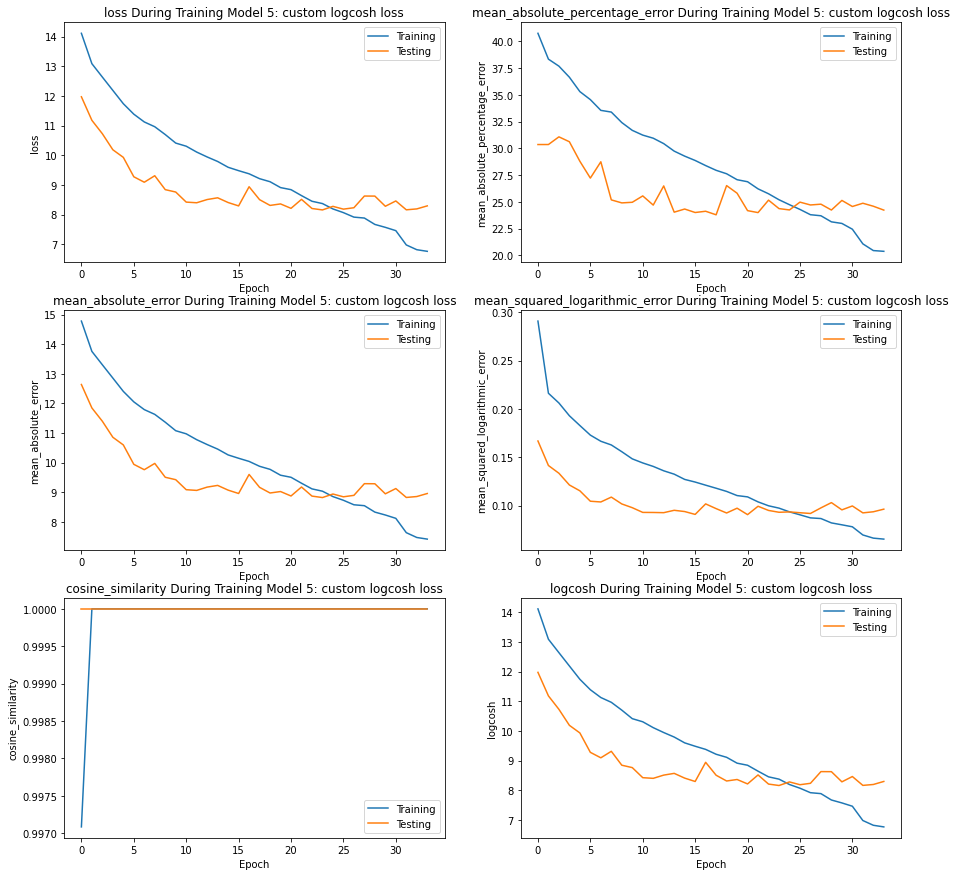

In [122]:
# === Plot the traing and validation performance of model 5 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 5: custom logcosh loss' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [123]:
#a little memory-based housekeeping
del model5
gc.collect()

25773

## Task 6: Model 6:: CNN model with a custom loss, named "hubosh loss" (10pts)
* Let's define a new loss function, namely `hubosh` loss which combines both `huber` and `logcosh` losses. That is, 
$$ hubosh(y, \hat{y}) = huber(y,\hat{y}) + logcosh(y,\hat{y})$$
* The gradient descent during optimizing the `hubosh` loss will try to minimize the sum of `huber` and `logcosh` losses, in term minimizing both!
* Can you figure out whether `hubosh` loss would still be a convex function?

In [124]:
def TF_hubosh(y_true, y_pred, delta=1.345):
    # This function takes two numpy arrays / 1-D tensors of same length, a delta.
    # And, it computes the hubosh loss (y_true , y_pred). 
    # Please note, all the operations needs to be tensor operations to be able to use it during training.
    # Finally, it returns the logcosh loss.
    y_true = tf.cast(y_true, dtype=tf.float32) #cast to a specific dtype
    y_pred = tf.cast(y_pred, dtype=tf.float32) #cast to a specific dtype
    
    hubosh_loss = tf.constant(np.inf, dtype=tf.float32) #positive infinity
    
    # YOUR CODE HERE
    loss1 = TF_huber(y_true, y_pred, delta)
    loss2 = TF_logcosh(y_true, y_pred)
    hubosh_loss = tf.add(loss1, loss2)
    #end of the code
    return hubosh_loss 

In [125]:
# Just checking if you have defined the function correctly. A valid function will pass the 3 assertions quietly.
assert(np.abs(TF_hubosh([1, 2, 3, 4], [-1, -2, -3, -4]).numpy()-10.131964) < 1e-3)
assert(np.abs(TF_hubosh([1, 2, 3, 4], [1, 2, 3, 4]).numpy()-0.0) < 1e-3)
assert(np.abs(TF_hubosh([41, 45, 49, 47, 44], [43.6, 44.4, 45.2, 46, 46.8]).numpy()- 3.6149244) <1e-3)

In [126]:
# I've called my_CNN_model_A() function following the requirements above. 
# Please note: your defined custom hubosh function (TF_hubosh) was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.
model6 = my_CNN_model_A(loss=TF_hubosh,
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [127]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard


epochs = 50 #number of epochs
batch_size = 128 #batch size

#training and validation dataset are ready
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#model save prefix path
model_path = 'saved_models/model6.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

In [128]:
# Now, call the lets_train_model() above with appropriate parameters to train model6.
# Please store the list of [history, model6] returned from the call.

# YOUR CODE HERE
[history, model6] = lets_train_model(model6, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
#end of the code

Epoch 1/128
686/686 [==============================] - 171s 247ms/step - loss: 33.2734 - mean_absolute_percentage_error: 40.7800 - mean_absolute_error: 14.8537 - mean_squared_logarithmic_error: 0.3033 - cosine_similarity: 0.9974 - logcosh: 14.1803 - val_loss: 27.7772 - val_mean_absolute_percentage_error: 34.2356 - val_mean_absolute_error: 12.5091 - val_mean_squared_logarithmic_error: 0.1491 - val_cosine_similarity: 1.0000 - val_logcosh: 11.8364 - lr: 0.0010
Epoch 2/128
686/686 [==============================] - 172s 250ms/step - loss: 30.6414 - mean_absolute_percentage_error: 38.4100 - mean_absolute_error: 13.7301 - mean_squared_logarithmic_error: 0.2183 - cosine_similarity: 1.0000 - logcosh: 13.0581 - val_loss: 26.1778 - val_mean_absolute_percentage_error: 33.8539 - val_mean_absolute_error: 11.8268 - val_mean_squared_logarithmic_error: 0.1382 - val_cosine_similarity: 1.0000 - val_logcosh: 11.1546 - lr: 0.0010
Epoch 3/128
686/686 [==============================] - 172s 250ms/step - los

Epoch 19/128
686/686 [==============================] - 173s 252ms/step - loss: 21.3775 - mean_absolute_percentage_error: 27.7455 - mean_absolute_error: 9.7713 - mean_squared_logarithmic_error: 0.1153 - cosine_similarity: 1.0000 - logcosh: 9.1091 - val_loss: 19.4203 - val_mean_absolute_percentage_error: 25.3694 - val_mean_absolute_error: 8.9349 - val_mean_squared_logarithmic_error: 0.0921 - val_cosine_similarity: 1.0000 - val_logcosh: 8.2746 - lr: 0.0010
Epoch 20/128
686/686 [==============================] - 172s 250ms/step - loss: 21.2506 - mean_absolute_percentage_error: 27.2936 - mean_absolute_error: 9.7177 - mean_squared_logarithmic_error: 0.1135 - cosine_similarity: 1.0000 - logcosh: 9.0550 - val_loss: 19.5538 - val_mean_absolute_percentage_error: 24.0745 - val_mean_absolute_error: 8.9912 - val_mean_squared_logarithmic_error: 0.0929 - val_cosine_similarity: 1.0000 - val_logcosh: 8.3319 - lr: 0.0010
Epoch 21/128
686/686 [==============================] - 172s 251ms/step - loss: 20

In [129]:
#saving model6
save_model(model_path, model=model6, name='Model6', description='CNN-A with custom Hubosh loss')

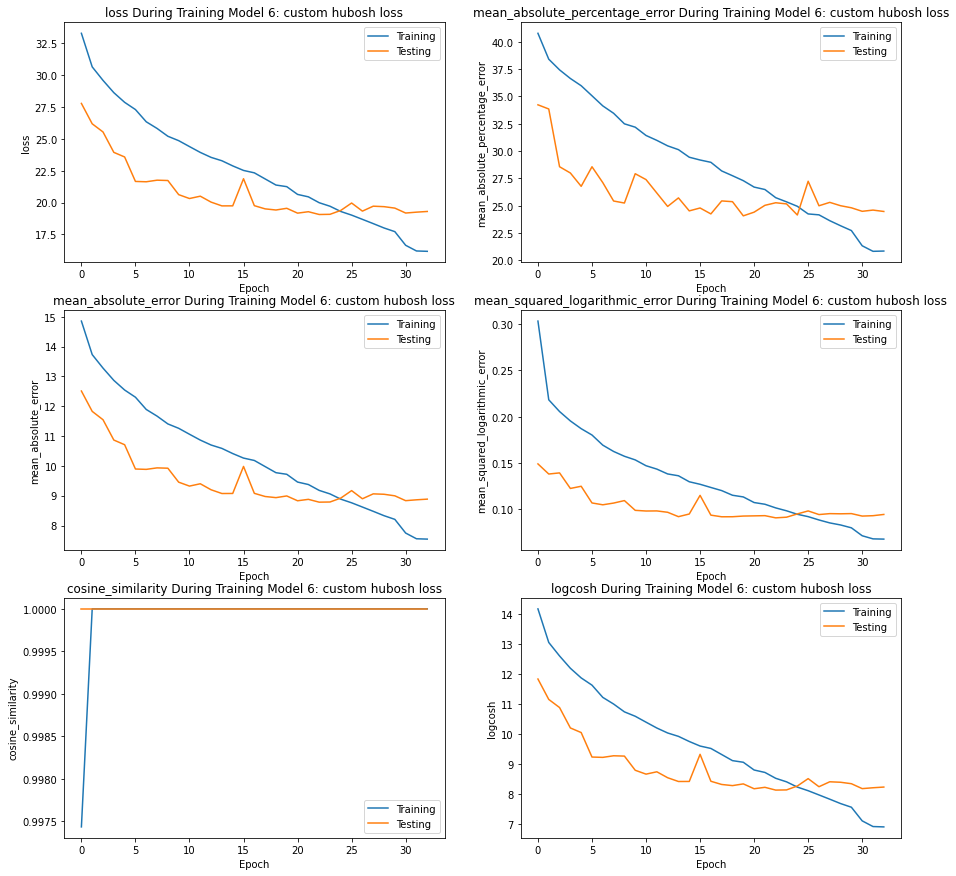

In [130]:
# === Plot the training and validation performance of model6 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model 6: custom hubosh loss' )
    plt.legend( )

# === Display the Chart === #
plt.show( )

In [131]:
#a little housekeeping
del model6
gc.collect()

24106

## Task 7: Model 7:: Yet another CNN model, with MSE loss (10pts)


* Here below is CNN_C architecture. Please construct it.

Model: "sequential"

| Layer type| Output Shape | Param # (roughly)|
| :----------- | :----------- |------------|
Conv2D          |     (None, 98, 98, 32)   |     320       |
Conv2D          |     (None, 96, 96, 32)   |     9248      |
MaxPooling2D    |     (None, 48, 48, 32)   |    0          |
Conv2D          |     (None, 46, 46, 64)   |     18496     |
Conv2D          | (None, 44, 44, 64)       | 36928     |
MaxPooling2D    |  (None, 22, 22, 64)      |  0         |        
Conv2D          | (None, 20, 20, 128)      | 73856     |
Conv2D          | (None, 18, 18, 128)      |  147584    |
MaxPooling2D    | (None, 9, 9, 128)        | 0         |
Conv2D          | (None, 7, 7, 256)        | 295168    |
Conv2D          | (None, 5, 5, 256)        | 590080    |
MaxPooling2D    | (None, 2, 2, 256)        | 0         |
Flatten         | (None, 1024)             | 0         |
Dense           | (None, 32)               | 32800     |
Dense           | (None, 32)               | 1056      |
Dropout         |(None, 32)                | 0         |
Dense           | (None, 1)                | 33  |

In [132]:
def my_CNN_model_C(loss,optimizer,metrics):
    #construct the model following the architecture above and return the model
    # YOUR CODE HERE
    model = Sequential()
    
    #1st convolution layer
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid', input_shape=(100, 100, 1)))

    #2nd convolution layer
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='valid'))

    #4th convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    #5th convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='valid'))

    #6th convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2)))

     #7th convolution layer
    model.add(Conv2D(256, (3, 3), activation='relu', strides=(1,1), padding='valid'))

    #8th convolution layer
    model.add(Conv2D(256, (3, 3), activation='relu', strides=(1,1), padding='valid'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))
    #end of code
    
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=metrics)
    return model



In [133]:
# I've called my_CNN_model_C() function following the requirements above. 
# Please note: your defined built-in MSE function was passed for the training. 
# So, good luck!
# Please take a careful note at how it was called.

model7 = my_CNN_model_C(loss='mean_squared_error',
                           optimizer='adam',
                           metrics=[
                                    'mean_absolute_percentage_error',
                                    'mean_absolute_error',
                                    'mean_squared_logarithmic_error',
                                    'cosine_similarity',
                                    'logcosh'
                                   ]
                          )

In [134]:
# YOUR CODE HERE
assert  check_network_architecture(model7, 
                                  expected_layer_shapes=[(None, 98, 98, 32), (None, 96, 96, 32), (None, 48, 48, 32), (None, 46, 46, 64), (None, 44, 44, 64), (None, 22, 22, 64), (None, 20, 20, 128), (None, 18, 18, 128), (None, 9, 9, 128), (None, 7, 7, 256), (None, 5, 5, 256), (None, 2, 2, 256), (None, 1024), (None, 32), (None, 32), (None, 32), (None, 1)],
                                  expected_params=1205569,
                                  expected_loss_function='mean_squared_error') == True

#end of the code

In [135]:
# YOUR CODE HERE
# Load the TensorBoard notebook extension
%reload_ext tensorboard

epochs = 50 #num of epochs
batch_size = 128 #batch size

#train-test datasets ready to be trained
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#prefix to the model save path
model_path = 'saved_models/model7.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

#end of the code

In [136]:
# Now, call the lets_train_model() above with appropriate parameters to train model7.
# Please store the list of [history, model7] returned from the call.

# YOUR CODE HERE
[history, model7] = lets_train_model(model7, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
#end of the code

Epoch 1/128
686/686 [==============================] - 489s 712ms/step - loss: 428.0628 - mean_absolute_percentage_error: 45.3076 - mean_absolute_error: 15.8169 - mean_squared_logarithmic_error: 0.3956 - cosine_similarity: 0.9989 - logcosh: 15.1412 - val_loss: 313.8552 - val_mean_absolute_percentage_error: 42.2704 - val_mean_absolute_error: 13.8590 - val_mean_squared_logarithmic_error: 0.1752 - val_cosine_similarity: 1.0000 - val_logcosh: 13.1790 - lr: 0.0010
Epoch 2/128
686/686 [==============================] - 492s 718ms/step - loss: 361.1159 - mean_absolute_percentage_error: 42.4510 - mean_absolute_error: 14.5723 - mean_squared_logarithmic_error: 0.2304 - cosine_similarity: 1.0000 - logcosh: 13.8982 - val_loss: 280.0226 - val_mean_absolute_percentage_error: 35.0059 - val_mean_absolute_error: 12.3238 - val_mean_squared_logarithmic_error: 0.1450 - val_cosine_similarity: 1.0000 - val_logcosh: 11.6484 - lr: 0.0010
Epoch 3/128
686/686 [==============================] - 491s 716ms/step -

Epoch 19/128
686/686 [==============================] - 488s 711ms/step - loss: 114.5482 - mean_absolute_percentage_error: 22.8802 - mean_absolute_error: 8.0235 - mean_squared_logarithmic_error: 0.0779 - cosine_similarity: 1.0000 - logcosh: 7.3671 - val_loss: 175.3870 - val_mean_absolute_percentage_error: 24.1136 - val_mean_absolute_error: 8.7302 - val_mean_squared_logarithmic_error: 0.0892 - val_cosine_similarity: 1.0000 - val_logcosh: 8.0729 - lr: 1.0000e-04
Epoch 20/128
686/686 [==============================] - 488s 711ms/step - loss: 107.3216 - mean_absolute_percentage_error: 21.9722 - mean_absolute_error: 7.7371 - mean_squared_logarithmic_error: 0.0729 - cosine_similarity: 1.0000 - logcosh: 7.0820 - val_loss: 178.7454 - val_mean_absolute_percentage_error: 23.8910 - val_mean_absolute_error: 8.8204 - val_mean_squared_logarithmic_error: 0.0910 - val_cosine_similarity: 1.0000 - val_logcosh: 8.1647 - lr: 1.0000e-04
Epoch 21/128
686/686 [==============================] - 491s 716ms/ste

In [137]:
# YOUR CODE HERE
#saving model7
save_model(model_path, model=model7, name='Model7', description='CNN-C with built-in MSE loss')
#end of the code

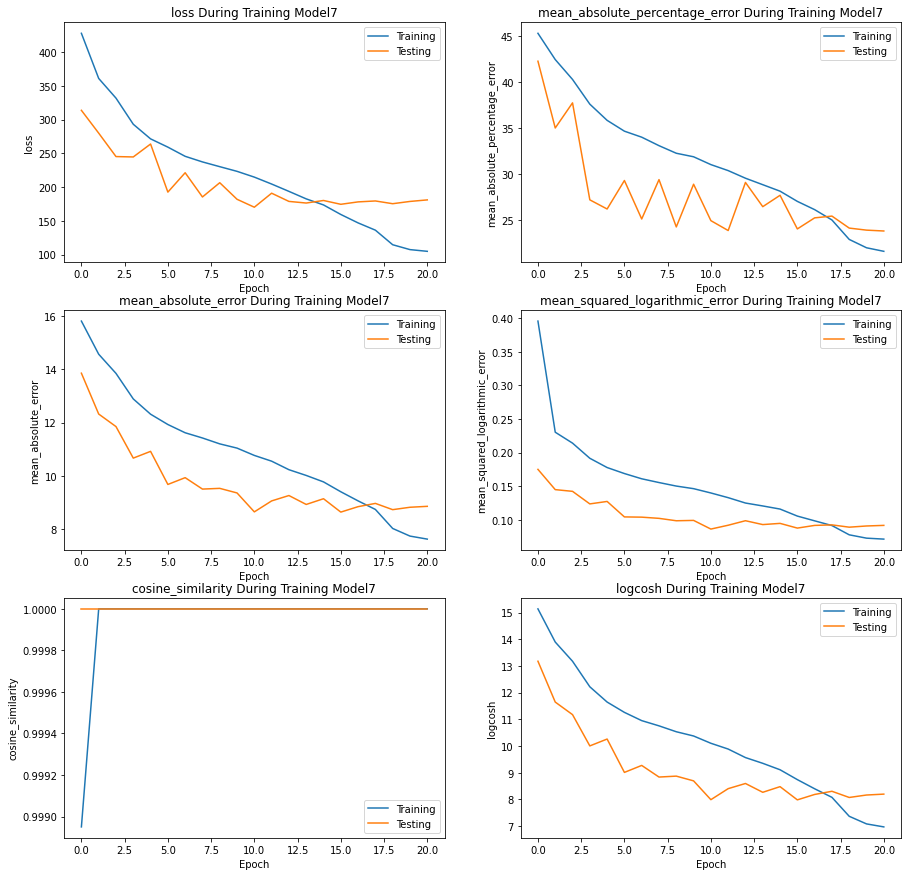

In [138]:
# YOUR CODE HERE
# === Plot the training and validation performance of model7 === #
metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Model7' )
    plt.legend( )

# === Display the Chart === #
plt.show( )
#end of the code

In [139]:
#a little housekeeping
del model7
gc.collect()

24726

## Task 8: Evaluating all 7 models against the judge dataset (10pts)

In [140]:
# Loading the judge dataset
judge_info = pd.read_csv( 'dataset/wiki_judge.csv' )
judge_info.head( )

,ID,full_path,gender,face_score,second_face_score
0,1,['1.png'],1.0,2.645639,1.949248
1,3,['3.png'],1.0,5.471801,NaN
2,4,['4.png'],1.0,3.582895,NaN
3,5,['5.png'],1.0,1.529254,NaN
4,6,['6.png'],1.0,1.241739,NaN


In [141]:
#Loading the judge images
X_judge_images = np.zeros( shape = (len(judge_info),100,100),dtype=np.float32)

i = 0
for p in judge_info.full_path:
    p = p.replace('[','').replace(']','').replace('\'','')
    fpath = '{}/{}'.format('dataset/wiki_judge/',p)
    X_judge_images[i] = cv2.imread(fpath,cv2.IMREAD_GRAYSCALE) / 255.0
    i += 1

print(X_judge_images.shape)
X_judge_images = X_judge_images.reshape(
    X_judge_images.shape[0],
    X_judge_images.shape[1],
    X_judge_images.shape[2],
    1
)
print(X_judge_images.shape)

(1399, 100, 100)
(1399, 100, 100, 1)


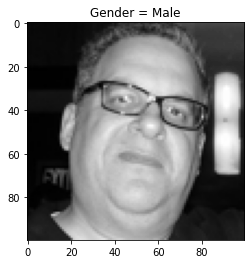

In [142]:
#Pick a random number and display it.
idx = random.randint(0,X_judge_images.shape[0])
img = X_judge_images[idx]
plt.figure()
plt.imshow(img.squeeze(), cmap='gray')
if judge_info.gender[idx]==0:
    gender = 'Female'
elif judge_info.gender[idx]==1:
    gender = 'Male'
else:
    gender = 'Unknown'
plt.title('Gender = {}'.format(gender))
plt.show()

In [148]:
# YOUR CODE HERE
[model1, number1, description1] = load_model("saved_models/model1.sav")
[model2, number2, description2] = load_model("saved_models/model2.sav")
[model3, number3, description3] = load_model("saved_models/model3.sav")
[model4, number4, description4] = load_model("saved_models/model4.sav")
[model5, number5, description5] = load_model("saved_models/model5.sav")
[model6, number6, description6] = load_model("saved_models/model6.sav")
[model7, number7, description7] = load_model("saved_models/model7.sav")
#Now predict the judge-set
def pred_judge(model, model_number):
    judge_pred = model.predict(X_judge_images)

    # === Construct Dataframe from Dictionary === #
    judge_pred_df = pd.DataFrame( {
                                    'ID': judge_info['ID'],
                                    'age': judge_pred.flatten( )
                                  })
    #Saving the judge_pred_df dataframe into 'dataset/judge_pred_df.csv' file.
    judge_pred_df.to_csv( 'saved_models/judge_pred_df_'+model_number+'.csv' , index=False )
    #Checking your judge predictions to put some score.
    files = {'judge_pred': open('saved_models/judge_pred_df_'+model_number+'.csv', 'rb')}
    response = requests.post(
                            url='http://54.160.44.72/csci5931sp22/check-PA2-judge-pred.php', 
                            files=files,
                            data = {'submit':'submit'})
    assert response.ok == True
    print(model_number+":\n")
    print(response.text)
    print("\n")

In [149]:
pred_judge(model1,'Model1')
pred_judge(model2,'Model2')
pred_judge(model3,'Model3')
pred_judge(model4,'Model4')
pred_judge(model5,'Model5')
pred_judge(model6,'Model6')
pred_judge(model7,'Model7')

Model1:

RMSE of your model is 12.165151441404




Model2:

RMSE of your model is 12.383434692358




Model3:

RMSE of your model is 12.122357126321




Model4:

RMSE of your model is 12.100110670983




Model5:

RMSE of your model is 12.041373704378




Model6:

RMSE of your model is 11.77552153559




Model7:

RMSE of your model is 11.883319218522






## Task 9: Can you do better than all of these 7 models? Try here... (10pts)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 conv2d_33 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_3 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 46, 46, 64)       

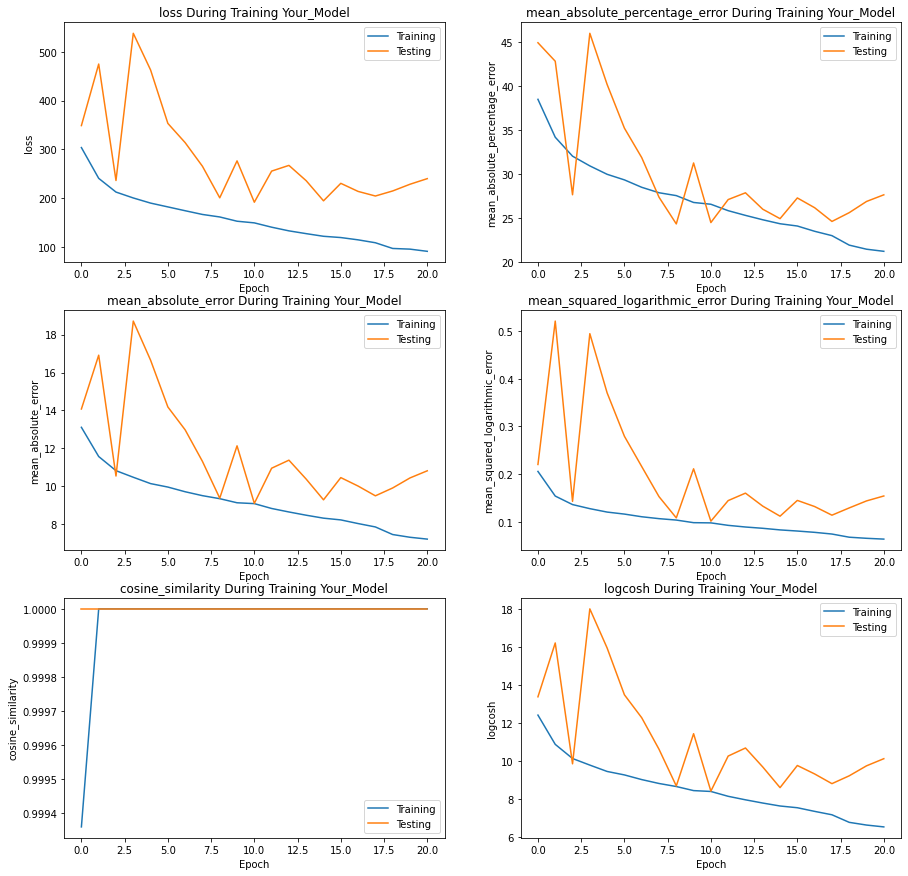

In [150]:
your_model = Sequential()
# YOUR CODE HERE
#1st convolution layer
your_model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid', input_shape=(100, 100, 1)))
#2nd convolution layer
your_model.add(Conv2D(32, (3, 3), activation='relu', strides=(1,1), padding='valid'))
your_model.add(BatchNormalization())
your_model.add(Dropout(0.2))
your_model.add(MaxPool2D(pool_size=(2, 2)))

#3rd convolution layer
your_model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='valid'))

#4th convolution layer
your_model.add(Conv2D(64, (3, 3), activation='relu', strides=(1,1), padding='valid'))
your_model.add(BatchNormalization())
your_model.add(Dropout(0.3))
your_model.add(MaxPool2D(pool_size=(2, 2)))

#5th convolution layer
your_model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='valid'))

#6th convolution layer
your_model.add(Conv2D(128, (3, 3), activation='relu', strides=(1,1), padding='valid'))
your_model.add(BatchNormalization())
your_model.add(Dropout(0.4))
your_model.add(MaxPool2D(pool_size=(2, 2)))

your_model.add(Flatten())
your_model.add(Dense(64, activation='relu'))
your_model.add(Dense(64, activation='relu'))

your_model.add(Dropout(0.5))
your_model.add(Dense(1, activation='linear'))
#end of code
    
your_model.compile(loss='mean_squared_error',
                        optimizer='adam',
                        metrics=[
                                'mean_absolute_percentage_error',
                                'mean_absolute_error',
                                'mean_squared_logarithmic_error',
                                'cosine_similarity',
                                'logcosh'
                                ])

your_model.summary()

# Load the TensorBoard notebook extension
%reload_ext tensorboard

epochs = 50 #num of epochs
batch_size = 128 #batch size

#train-test datasets ready to be trained
x_train = X_train_images
y_train = y_train
x_test = X_test_images
y_test = y_test

#prefix to the model save path
model_path = 'saved_models/your_model.sav'

#tensorboard log directory for each training
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#tensorboard call back to be called during training
tensorboard_cbk = TensorBoard(log_dir=log_dir, histogram_freq=1)
#early stopping call back to be called during training
early_stopping_cbk = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
#Model Checkpoint call back to be called during training to save best model based on validation loss
mcp_save_cbk = ModelCheckpoint(model_path+'.mcp.hdf5', save_best_only=True, monitor='val_loss', mode='min')
#Reduce learning rate callback to be called during training when a plateau was encountered... 
# remember the issue with "saddle point" -- on a horse?
reduce_lr_plateau_cbk = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
# gather all these callbacks to be passed during training (i.e., model.fit())
callbacks = [early_stopping_cbk, mcp_save_cbk, reduce_lr_plateau_cbk, tensorboard_cbk]

[history, your_model] = lets_train_model(your_model, x_train, y_train, epochs, batch_size, x_test, y_test, callbacks)
# saving model2
save_model(model_path, model=your_model, name='Your_Model', description='Your CNN with built-in MSE loss')

metrics = ['loss','mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_logarithmic_error', 'cosine_similarity', 'logcosh']
plt.figure( figsize=(15,15) )
for i in np.arange(6):
    plt.subplot(3, 2, i+1)
    plt.plot( history.history[metrics[i]] , label='Training' )
    plt.plot( history.history['val_'+metrics[i]] , label='Testing' )

    # === Label the Chart === #
    plt.xlabel( 'Epoch' )
    plt.ylabel( metrics[i] )
    plt.title( metrics[i]+' During Training Your_Model' )
    plt.legend( )

# === Display the Chart === #
plt.show( )


In [151]:
##Now predict the judge-set
judge_pred = your_model.predict( X_judge_images)

# === Construct Dataframe from Dictionary === #
judge_pred_df = pd.DataFrame( {
                                'ID': judge_info['ID'],
                                'age': judge_pred.flatten( )
                              })
#Saving the judge_pred_df dataframe into 'dataset/judge_pred_df.csv' file.
judge_pred_df.to_csv( 'saved_models/judge_pred_df_yourModel.csv' , index=False )
#Checking your judge predictions to put some score.
files = {'judge_pred': open('saved_models/judge_pred_df_yourModel.csv', 'rb')}
response = requests.post(
                            url='http://54.160.44.72/csci5931sp22/check-PA2-judge-pred.php', 
                            files=files,
                            data = {'submit':'submit'})
assert response.ok == True
print("Your Model:\n")
print(response.text)
print("\n")

Your Model:

RMSE of your model is 14.760830828654




